**《深度学习之 PyTorch 实战》**

讲师作者：[土豆老师](https://iphysresearch.github.io)

# 计算机视觉

近年来，深度学习一直是提高计算机视觉系统性能的变革力量。 无论是医疗诊断、自动驾驶车辆，还是智能滤镜、摄像头监控，许多计算机视觉领域的应用都与我们当前和未来的生活密切相关。 可以说，最先进的计算机视觉应用程序与深度学习几乎是不可分割的。 有鉴于此，本讲将重点介绍计算机视觉领域，并探讨最近在学术界和行业中具有影响力的方法和应用。


## 实战 Kaggle 比赛：图像分类 (CIFAR-10)

>(Restart your kernel here)

之前几节中，我们一直在使用深度学习框架的高级API直接获取张量格式的图像数据集。 但是在实践中，图像数据集通常以图像文件的形式出现。 在本节中，我们将从原始图像文件开始，然后逐步组织、阅读，然后将它们转换为张量格式。

我们在「图像增广」节中对 CIFAR-10 数据集做了一个实验，这是计算机视觉领域中的一个重要的数据集。 在本节中，我们将运用我们在前几节中学到的知识来参加涉及 CIFAR-10 图像分类问题的 Kaggle 竞赛，比赛的网址是 https://www.kaggle.com/c/cifar-10。

下图显示了竞赛网站页面上的信息。 为了能提交结果，你需要首先注册 Kaggle 账户。

![](https://i.loli.net/2021/06/04/NqcoETCH6MxYX5u.png)


（CIFAR-10 图像分类竞赛页面上的信息。竞赛用的数据集可通过点击“Data”选项卡获取。）

首先，导入竞赛所需的包和模块。

In [3]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
import dl4wm

### 获取并组织数据集

比赛数据集分为训练集和测试集，其中训练集包含 50000 张、测试集包含 300000 张图像。 在测试集中，10000 张图像将被用于评估，而剩下的 290000 张图像将不会被进行评估，包含它们只是为了防止手动标记测试集并提交标记结果。 两个数据集中的图像都是 png 格式，高度和宽度均为 32 像素并有三个颜色通道(RGB)。 这些图片共涵盖 10 个类别：飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车。 上图的左上角显示了数据集中飞机、汽车和鸟类的一些图像。

#### 下载数据集

登录 Kaggle 后，我们可以点击上图中显示的 CIFAR-10 图像分类竞赛网页上的 “Data” 选项卡，然后单击 “Download All” 按钮下载数据集。 在 ../data 中解压下载的文件并在其中解压缩 `train.7z` 和 `test.7z` 后，你将在以下路径中找到整个数据集：

- `../data/cifar-10/train/[1-50000].png`

- `../data/cifar-10/test/[1-300000].png`

- `../data/cifar-10/trainLabels.csv`

- `../data/cifar-10/sampleSubmission.csv`

train 和 test 文件夹分别包含训练和测试图像，`trainLabels.csv` 含有训练图像的标签， `sample_submission.csv` 是提交文件的范例。

为了便于入门，本节提供包含前 1000 个训练图像和 5 个随机测试图像的数据集的小规模样本。 要使用 Kaggle 竞赛的完整数据集，你需要将以下 demo 变量设置为 False。

```python
import requests
import hashlib
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download(name, cache_dir=os.path.join('.', 'Datasets')):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_all():
    """Download all files in the DATA_HUB."""
    for name in DATA_HUB:
        download(name)
```

In [4]:
dl4wm.DATA_HUB['cifar10_tiny'] = (dl4wm.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# 如果你使用完整的Kaggle竞赛的数据集，设置`demo`为 False
demo = True

if demo:
    data_dir = dl4wm.download_extract('cifar10_tiny')
else:
    data_dir = './Datasets/kaggle_cifar10_tiny/'

# Downloading ./Datasets/kaggle_cifar10_tiny.zip from http://d2l-data.s3-accelerate.amazonaws.com/kaggle_cifar10_tiny.zip...    


#### 整理数据集

我们需要整理数据集来训练和测试模型。 首先，我们用以下函数读取 csv 文件中的标签，它返回一个字典，该字典将文件名中不带扩展名的部分映射到其标签。


```python
def read_csv_labels(fname):
    """读取 `fname` 来给标签字典返回一个文件名。"""
    with open(fname, 'r') as f:
        # 跳过文件头行 (列名)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

```

In [11]:
def read_csv_labels(fname):
    """读取 `fname` 来给标签字典返回一个文件名。"""
    with open(fname, 'r') as f:
        # 跳过文件头行 (列名)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

In [12]:
labels = dl4wm.read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# 训练示例 :', len(labels))
print('# 类别 :', len(set(labels.values())))

# 训练示例 : 1000
# 类别 : 10


接下来，我们定义 `reorg_train_valid` 函数来将验证集从原始的训练集中拆分出来。 此函数中的参数 `valid_ratio` 是验证集中的示例数与原始训练集中的示例数之比。 更具体地说，令  𝑛  等于示例最少的类别中的图像数量，而  𝑟  是比率。 验证集将为每个类别拆分出  max(⌊𝑛𝑟⌋,1)  张图像。 让我们以 `valid_ratio=0.1` 为例，由于原始的训练集有 50000 张图像，因此 `train_valid_test/train` 路径中将有 45000 张图像用于训练，而剩下 5000 张图像将作为路径 `train_valid_test/valid` 中的验证集。 组织数据集后，同类别的图像将被放置在同一文件夹下。

```python
def copyfile(filename, target_dir):
    """将文件复制到目标目录。"""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
    # 训练数据集中示例最少的类别中的示例数
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # 验证集中每个类别的示例数
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(
            fname,
            os.path.join(data_dir, 'train_valid_test', 'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(
                fname,
                os.path.join(data_dir, 'train_valid_test', 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(
                fname,
                os.path.join(data_dir, 'train_valid_test', 'train', label))
    return n_valid_per_label
```

In [13]:
def copyfile(filename, target_dir):
    """将文件复制到目标目录。"""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
    # 训练数据集中示例最少的类别中的示例数
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # 验证集中每个类别的示例数
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(
            fname,
            os.path.join(data_dir, 'train_valid_test', 'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(
                fname,
                os.path.join(data_dir, 'train_valid_test', 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(
                fname,
                os.path.join(data_dir, 'train_valid_test', 'train', label))
    return n_valid_per_label

下面的 `reorg_test` 函数用来在预测期间组织测试集以便读取。

```python
def reorg_test(data_dir):
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(
            os.path.join(data_dir, 'test', test_file),
            os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))
```

最后，我们使用一个函数来调用上面定义的 `read_csv_labels` 、 `reorg_train_valid` 和 `reorg_test` 函数。

```python
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)
```

在这里，我们只将样本数据集的批量大小设置为 4。 在实际训练和测试中，应该使用 Kaggle 竞赛的完整数据集，并将 batch_size 设置为更大的整数，例如 128。 我们将 10％ 的训练示例作为调整超参数的验证集。

In [14]:
def reorg_test(data_dir):
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(
            os.path.join(data_dir, 'test', test_file),
            os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)


In [15]:
batch_size = 4 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

### 图像增广

我们使用图像增广来解决过拟合的问题。例如在训练中，我们可以随机水平翻转图像。 我们还可以对彩色图像的三个 RGB 通道执行标准化。 下面，我们列出了其中一些可以调整的操作。

In [16]:
transform_train = torchvision.transforms.Compose([
    # 在高度和宽度上将图像放大到40像素的正方形
    torchvision.transforms.Resize(40),
    # 随机裁剪出一个高度和宽度均为40像素的正方形图像，
    # 生成一个面积为原始图像面积0.64到1倍的小正方形，
    # 然后将其缩放为高度和宽度均为32像素的正方形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                             ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

在测试期间，我们只对图像执行标准化，以消除评估结果中的随机性。

In [17]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

### 读取数据集

接下来，我们读取由原始图像文件组成的组织数据集，每个示例都包括一张图片和一个标签。

In [18]:
train_ds, train_valid_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_test) for folder in ['valid', 'test']]

在训练期间，我们需要指定上面定义的所有图像增广操作。 当验证集在超参数调整过程中用于模型评估时，不应引入图像增广的随机性。 在最终预测之前，我们根据训练集和验证集组合而成的训练模型进行训练，以充分利用所有标记的数据。

In [19]:
train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

### 定义模型

我们定义了「残差网络（ResNet）」节中描述的 Resnet-18 模型。

In [20]:
def get_net():
    num_classes = 10
    net = dl4wm.resnet18(num_classes, 3)
    return net

loss = nn.CrossEntropyLoss(reduction="none")

### 定义训练函数

我们将根据模型在验证集上的表现来选择模型并调整超参数。 下面我们定义了模型训练函数 `train`。

In [21]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), dl4wm.Timer()
    animator = dl4wm.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'valid acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = dl4wm.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = dl4wm.train_batch_CV(net, features, labels, loss,
                                          trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[2], None))
        if valid_iter is not None:
            valid_acc = dl4wm.evaluate_accuracy_gpus(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    if valid_iter is not None:
        print(f'loss {metric[0] / metric[2]:.3f}, '
              f'train acc {metric[1] / metric[2]:.3f}, '
              f'valid acc {valid_acc:.3f}')
    else:
        print(f'loss {metric[0] / metric[2]:.3f}, '
              f'train acc {metric[1] / metric[2]:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

### 训练和验证模型

<!-- 现在，我们可以训练和验证模型了，而以下所有超参数都可以调整。 例如，我们可以增加周期的数量。当 `lr_period` 和 `lr_decay` 分别设置为 50 和 0.1 时，优化算法的学习速率将在每 50 个周期乘以 0.1。为了示范，我们在这里只训练一个周期。 -->

现在，我们可以训练和验证模型了，而以下所有超参数都可以调整。 例如，我们可以增加周期的数量。当 `lr_period` 和 `lr_decay` 分别设置为 4 和 0.9 时，优化算法的学习速率将在每 4 个周期乘以 0.9。 为便于演示，我们在这里只训练 20 个周期。

loss 0.998, train acc 0.684, valid acc 0.487
13.2 examples/sec on [device(type='cpu')]


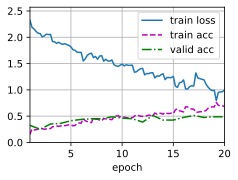

In [22]:
devices, num_epochs, lr, wd = dl4wm.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

### 在 Kaggle 上对测试集进行分类并提交结果

在获得具有超参数的满意的模型后，我们使用所有标记的数据（包括验证集）来重新训练模型，并对测试集进行分类。

loss 1.016, train acc 0.638
13.8 examples/sec on [device(type='cpu')]


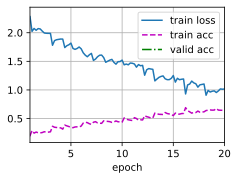

In [25]:
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)

向 Kaggle 提交结果的方法与「实战 Kaggle 比赛：预测房价」节中的方法类似，上面的代码将生成一个 `submission.csv` 文件，其格式符合 Kaggle 竞赛的要求。

### 小结

- 将包含原始图像文件的数据集组织为所需格式后，我们可以读取它们。

- 我们可以在图像分类竞赛中使用卷积神经网络和图像增广。